<a href="https://colab.research.google.com/github/aditya161205/DAV/blob/main/q2_DAV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data=pd.read_csv("student_data.csv")


In [3]:
numeric = data.select_dtypes(include=['float64']).columns
for col in numeric:
    data[col] = data[col].fillna(data[col].median())


cat = data.select_dtypes(include=['object']).columns
for col in cat:
    data[col] = data[col].fillna(data[col].mode()[0])

In [48]:
for col in data.columns:
    if data[col].dtype == 'float64':
        lower = data[col].quantile(0.25)
        upper = data[col].quantile(0.75)
        data[col] = data[col].clip(lower, upper)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Student_ID                     1000 non-null   object 
 1   Age                            1000 non-null   float64
 2   Gender                         1000 non-null   object 
 3   StudyHoursPerDay               1000 non-null   float64
 4   SocialMediaHours               1000 non-null   float64
 5   MovieTvShowHours               1000 non-null   float64
 6   PoR                            1000 non-null   object 
 7   AttendancePercentage           1000 non-null   float64
 8   SleepHoursPerNight             1000 non-null   float64
 9   Diet_Quality                   1000 non-null   object 
 10  Exercise_frequency             1000 non-null   float64
 11  parental_education_level       1000 non-null   object 
 12  internet_quality               1000 non-null   ob

In [56]:

data_encoded=pd.get_dummies(data,columns = ['Gender', 'PoR','Diet_Quality','parental_education_level','internet_quality','extracurricular_participation'], dtype = int, drop_first=True)

X = data_encoded.drop(['Cumulative_Grade', 'Student_ID'], axis=1)
y=data_encoded['Cumulative_Grade']


In [57]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)



In [58]:
class LinearRegression:
  def __init__(self)->None:
    self.weights: np.ndarray | None=None
    self.bias: np.ndarray | None=None

  def predict(self,X:np.ndarray)->np.ndarray:
    y_pred=np.dot(self.weights,X.T) + self.bias
    return y_pred

  def __loss(self,X:np.ndarray,y:np.ndarray,norm:int)->tuple:

    y_pred=self.predict(X)
    n=X.shape[0]

    errors=np.abs(y_pred-y)**norm
    loss=np.sum(errors)/n

    gradient_base= norm*np.sign(y_pred-y)*(np.abs(y_pred-y)**(norm-1))
    dw = np.dot(X.T, gradient_base) / n
    db = np.sum(gradient_base) / n

    return loss, dw, db

  def fit(self,X:np.ndarray,y:np.ndarray,learning_rate:float=0.01,epochs:int=500,norm: int = 2, threshold: float = 0.0001)->None:

    X = np.asarray(X, dtype=np.float64)
    y = np.asarray(y, dtype=np.float64)

    n_features = X.shape[1]

    self.weights = np.zeros(n_features, dtype=np.float64)
    self.bias = 0.0
    prev_loss = float('inf')

    for epoch in range (epochs):
      curr_loss,dw,db=self.__loss(X, y, norm)
      self.weights-=learning_rate*dw
      self.bias-=learning_rate*db

      if abs(curr_loss-prev_loss)<threshold:
        print(f"Converged at epoch {epoch + 1}. Loss: {curr_loss:.4f}")
        break
      prev_loss=curr_loss




MSE loss:  64.74849101707711


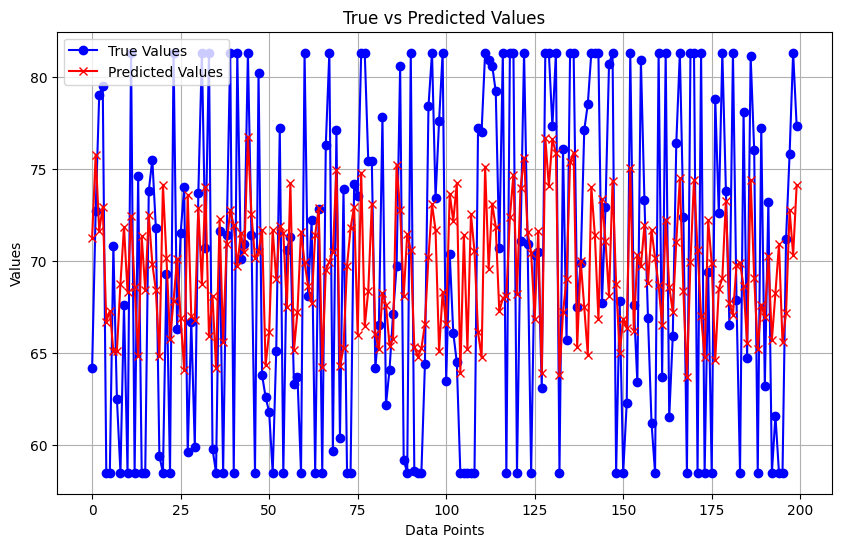

In [59]:
model = LinearRegression()
model.fit(X_train, y_train, epochs=1000, learning_rate=0.0001, norm=2, threshold=0.0001)
y_pred = model.predict(X_test)

print("MSE loss: ", np.mean((y_pred - y_test) ** 2))

indices = np.arange(len(y_test))
plt.figure(figsize=(10, 6))

plt.plot(indices, y_test, label='True Values', color='blue', marker='o')
plt.plot(indices, y_pred, label='Predicted Values', color='red', marker='x')

plt.xlabel('Data Points')
plt.ylabel('Values')
plt.title('True vs Predicted Values')

plt.legend()
plt.grid(True)
plt.show()